<a href="https://colab.research.google.com/github/valeriopagliarino/Electronics-2021-UNITO/blob/main/analysis/3_Mixer_Diff_Trigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis: mixer, differential stage, Schmitt's trigger
### October 7th 2021
<p>
Authors: <b> Stefano Barbero, Valerio Pagliarino, Matteo Barbagiovanni, Federico Malnati </b> <p>Electronics Laboratory 2021 - Department of Physics - University of Turin <p>
Date: 07/10/2021

1. OPA Mixer
2. OPA Differential Stage
3. OPA Schmitt's trigger


OPA: LM471CV (https://www.ti.com/lit/ds/symlink/lm741.pdf)


## Configuration

### Clone the GIT

In [1]:
!rm -r ./sample_data
import os
from getpass import getpass
user = input('GitHub user')
mail = input('GitHub email')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/valeriopagliarino/Electronics-2021-UNITO.git
!git config --global user.email user
!git config --global user.name mail

GitHub uservaleriopagliarino
GitHub emailvalerio.pagliarino@edu.unito.it
GitHub password··········
Cloning into 'Electronics-2021-UNITO'...
remote: Enumerating objects: 998, done.
remote: Counting objects: 100% (998/998), done.
remote: Compressing objects: 100% (699/699), done.
remote: Total 998 (delta 507), reused 625 (delta 274), pack-reused 0
Receiving objects: 100% (998/998), 40.89 MiB | 31.87 MiB/s, done.
Resolving deltas: 100% (507/507), done.


### Install environment

In [2]:
exec(open("./Electronics-2021-UNITO/analysis/ROOT-config.py").read())

Start config for JupyROOT Env. on Google Coolab - It takes about 3 minutes
WGET...
Done.
UNZIP...
TAR...
APT...
Installation completed.
Shared objects loaded.
Welcome to JupyROOT 6.14/04
Completed!


### Importa moduli [no COLAB]

In [ ]:
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from matplotlib import pyplot as plt

from uncertainties import ufloat
import uncertainties.umath

import pickle

import ROOT # Per COLAB importato da ROOT-config.py

DATADIR = "../data-source"
OUTPUTDIR = "./output"

### Importa moduli [COLAB]

In [3]:
%cd /content/
!pip3 install uncertainties
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from uncertainties import ufloat
import uncertainties.umath
from matplotlib import pyplot as plt
import pickle#Pickle with dict of Numpy arrays

# Variables for directories
DATADIR = "/content/Electronics-2021-UNITO/data-source"
OUTPUTDIR = "/content/Electronics-2021-UNITO/analysis/output"

/content
     |████████████████████████████████| 98 kB 3.0 MB/s 


### Funzioni per l'importazione file Tektronix

In [4]:
import csv

def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

## OPA Mixer

In [6]:
# Somma di sinusoidi identiche
s1_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_equal_sine/F0000CH1.CSV')
s1_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_equal_sine/F0000CH2.CSV')
# Somma di sinusoide e sua inversa
s2_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_inv_sine/F0002CH1.CSV')
s2_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_inv_sine/F0002CH2.CSV')
# Somma di sinusoidi di ampiezza diversa per check guadagno somma
s3_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_meas/F0005CH1.CSV')
s3_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_meas/F0005CH2.CSV')
# Somma di sinusoidi di frequenza diversa con battimenti
s4_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_modulation/F0004CH1.CSV')
s4_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_modulation/F0004CH2.CSV')
# Somma di sinusoide + onda quadra
s5_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_square/F0001CH1.CSV')
s5_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_sine_square/F0001CH2.CSV')
# Somma di onda quadra + rampa
s6_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_square_ramp/F0003CH1.CSV')
s6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_sum_square_ramp/F0003CH2.CSV')

## OPA Difference amplifier

In [8]:
# Differenza tra sinusoidi identiche
d1_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine/F0007CH1.CSV')
d1_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine/F0007CH2.CSV')
# Differenza tra sinusoidi identiche, zoom
d2_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine_detail/F0006CH1.CSV')
d2_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_eq_sine_detail/F0006CH2.CSV')
# Differenza tra sinusoide a media nulla e sinusoide con offset
d3_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_sine_square/F0008CH1.CSV')
d3_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_sine_square/F0008CH2.CSV')
# Differenza tra sinusoide e onda quadra
d4_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_get_offset/F0011CH1.CSV')
d4_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_get_offset/F0011CH2.CSV')
# Differenza tra onda quadra per verifica del guadagno della differenza
d5_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_meas/F0010CH1.CSV')
d5_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_meas/F0010CH2.CSV')
# Differenza tra onda quadra e rampa
d6_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_ramp/F0009CH1.CSV')
d6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_diff_square_ramp/F0009CH2.CSV')

## OPA Schmitt's trigger

In [14]:
# Trigger di Schmitt su segnale sinusoidale pulito
t1_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_clean/F0017CH1.CSV')
t1_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_clean/F0017CH2.CSV')
t1_ch3_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_clean/F0017CH3.CSV')
# Trigger di Schmitt per valutazione velocità di commutazione
t2_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_com_speed/F0018CH1.CSV')
t2_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_com_speed/F0018CH2.CSV')
t2_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_com_speed/F0018CH3.CSV')
# Segnale di ingresso
t3_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_input/F0012CH1.CSV')
t3_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_input/F0012CH2.CSV')
# Trigger di Schmitt, funzionamento con segnale dotato di rumore
t4_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation/F0015CH1.CSV')
t4_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation/F0015CH2.CSV')
t4_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation/F0015CH3.CSV')
# Trigger di Schmitt, funzionamento con segnale pulto
t5_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_clean/F0013CH1.CSV')
t5_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_clean/F0013CH2.CSV')
t5_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_clean/F0013CH3.CSV')
# Baseline trigger ad anello aperto, funzionamento con segnale dotato di rumore
t6_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH1.CSV')
t6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH2.CSV')
t6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_operation_open_ring/F0014CH3.CSV')
# Trigger di Schmitt, funzionamento fuori dal range di frequenza consentito
t6_ch1_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_out_of_range/F0016CH1.CSV')
t6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_out_of_range/F0016CH2.CSV')
t6_ch2_f = openTek(f'{DATADIR}/7-10-21/OPA_trigger_out_of_range/F0016CH3.CSV')

## Visualizzazioni XY

CH1 vs CH2

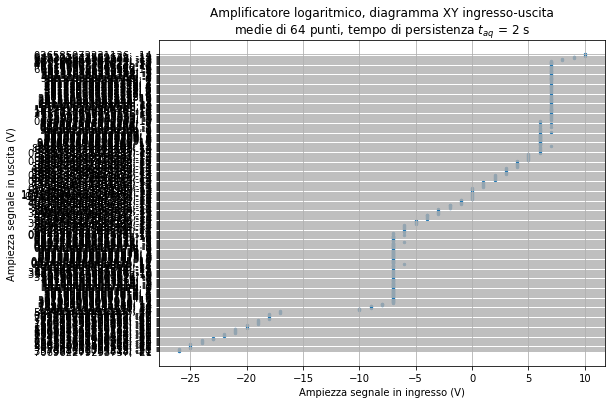

In [16]:
logXY = pd.read_csv(f"{DATADIR}/7-10-21/XY/Hist_100Hz.csv")

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))
ax.scatter(logXY.to_numpy().transpose()[0], logXY.to_numpy().transpose()[1], s=6)

ax.set(xlabel='Ampiezza segnale in ingresso (V)', ylabel='Ampiezza segnale in uscita (V)',
       title='Amplificatore logaritmico, diagramma XY ingresso-uscita\nmedie di 64 punti, tempo di persistenza $t_{aq}$ = 2 s')

ax.grid()

## Commit changes

In [ ]:
%cd /content/Electronics-2021-UNITO/
!git pull
!git add .
!git commit -m "Plots from data analysis"
!git push 